In [1]:
import pandas as pd

from micropattern_analysis import *
from support_functions import *

#from statannotations.Annotator import Annotator
from toolz import pipe

In [2]:
dir = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS1_MP_ISTA_MIFF1"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['18h', '24h', '28h', 'Control']


In [3]:
dirs = dirs[0:3]
print(dirs)

['18h', '24h', '28h']


In [4]:
file_names, images = zip(*get_files_and_images(dirs).items())

In [7]:
file_names = list(file_names[2:-1])
images = list(images[2:-1])

### 18h time point

In [8]:
cur_file_index = string_list_locations(file_names, "18h")

cur_images = get_items_from_index(images, cur_file_index)
cur_images = list(map(
    lambda x: maximise_and_normalize(x),
    cur_images
))

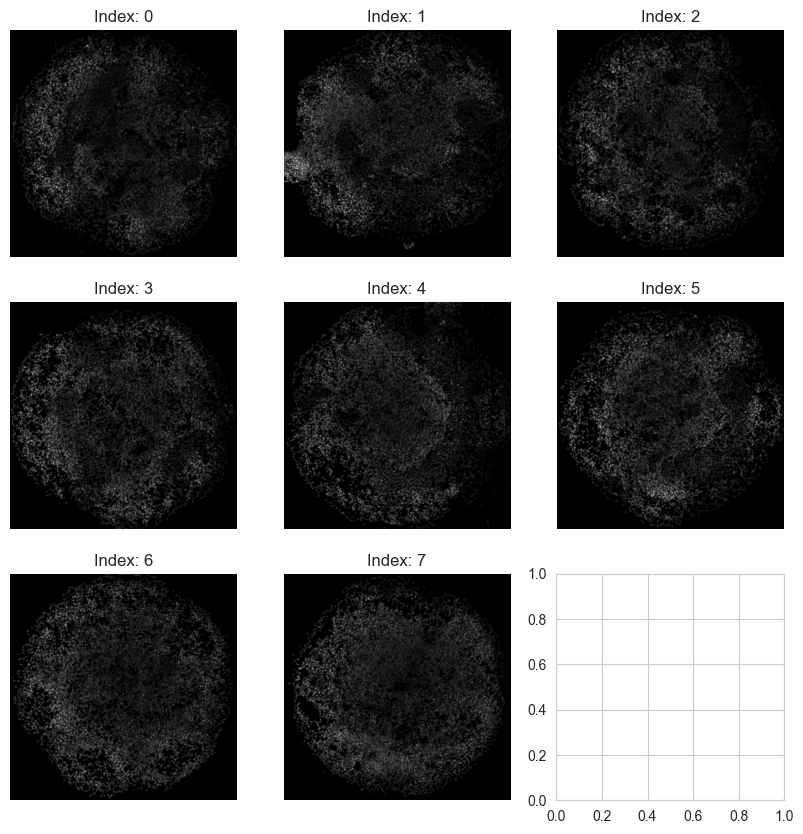

In [14]:
channel = 1
fig, ax = plot_images(cur_images, channel)

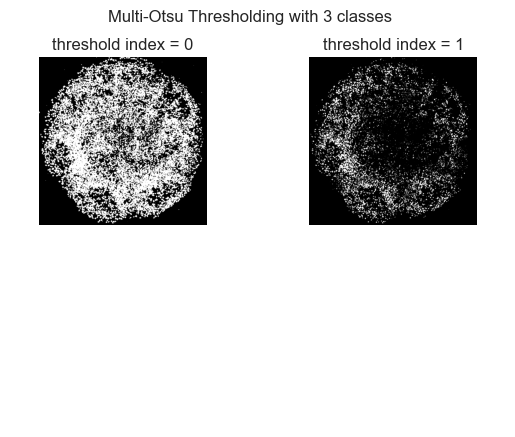

In [16]:
plot_multi_otsu_thresholds(cur_images[6], channel, 3)

In [17]:
index_to_exclude = [0, 1, 2, 4, 5]
cur_images = delete_from_list(cur_images, index_to_exclude)
cur_file_indexes = delete_from_list(cur_file_index, index_to_exclude)

dapi_num = 1

images_new = list(map(
    lambda x:
    pipe(
        x,
        lambda f: apply_multiotsu_to_image(f, dapi_num, num_classes=3, threshold_index=0),
        lambda f: apply_multiotsu_to_channel(f, 0, num_classes=3, threshold_index=0)
    ),
    cur_images)
)

file_names_new = get_items_from_index(file_names, cur_file_indexes)

### 24h time point

In [18]:
cur_file_index = string_list_locations(file_names, "24h")

cur_images = get_items_from_index(images, cur_file_index)
cur_images = list(map(
    lambda x: maximise_and_normalize(x),
    cur_images
))

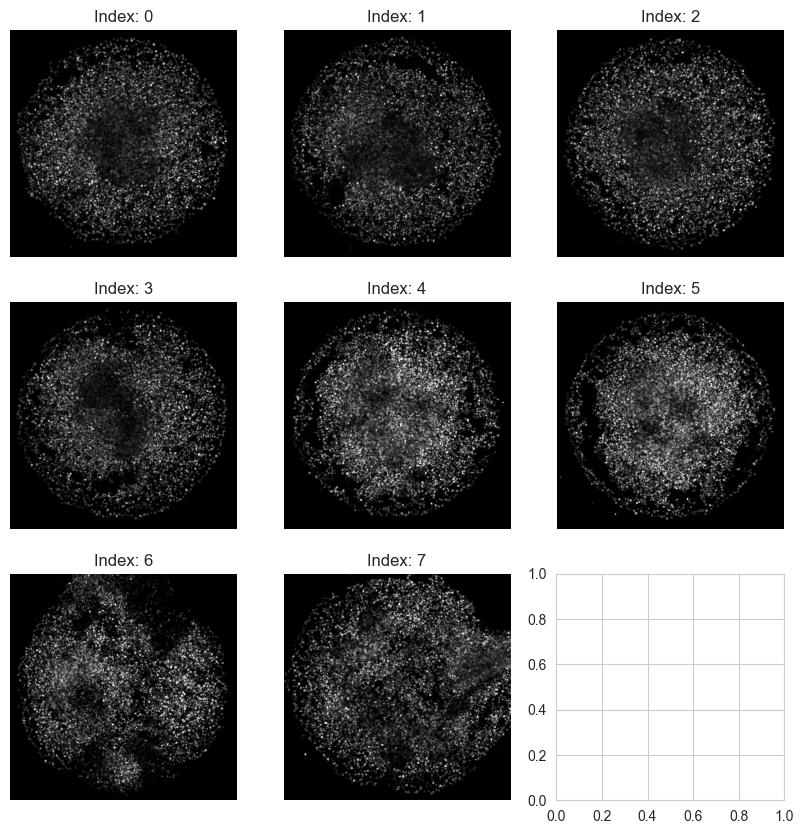

In [23]:
channel = 0
fig, ax = plot_images(cur_images, channel)

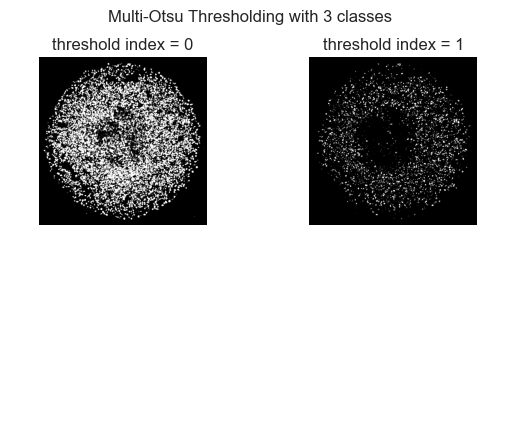

In [24]:
plot_multi_otsu_thresholds(cur_images[2], channel, 3)

In [25]:
index_to_exclude = [3, 4, 5, 6, 7]
cur_images = delete_from_list(cur_images, index_to_exclude)
cur_file_indexes = delete_from_list(cur_file_index, index_to_exclude)

dapi_num = 1

images_new.extend(list(map(
    lambda x:
    pipe(
        x,
        lambda f: apply_multiotsu_to_image(f, dapi_num, num_classes=3, threshold_index=0),
        lambda f: apply_multiotsu_to_channel(f, 0, num_classes=3, threshold_index=0)
    ),
    cur_images)
))

file_names_new.extend(get_items_from_index(file_names, cur_file_indexes))

### 28h time point

In [26]:
cur_file_index = string_list_locations(file_names, "28h")

cur_images = get_items_from_index(images, cur_file_index)
cur_images = list(map(
    lambda x: maximise_and_normalize(x),
    cur_images
))

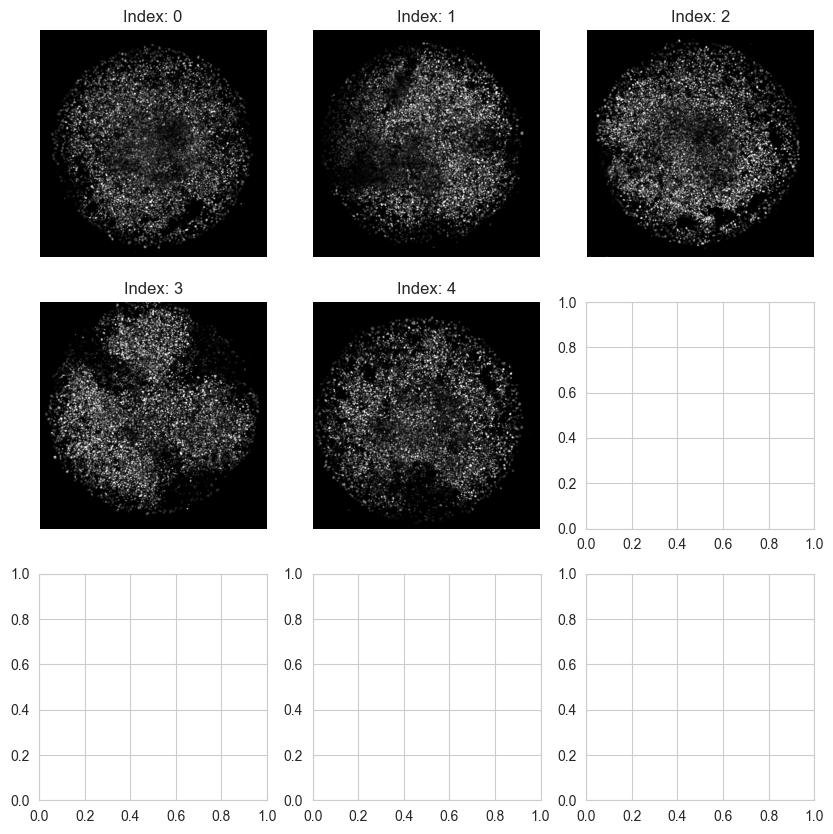

In [31]:
channel = 0
fig, ax = plot_images(cur_images, channel)

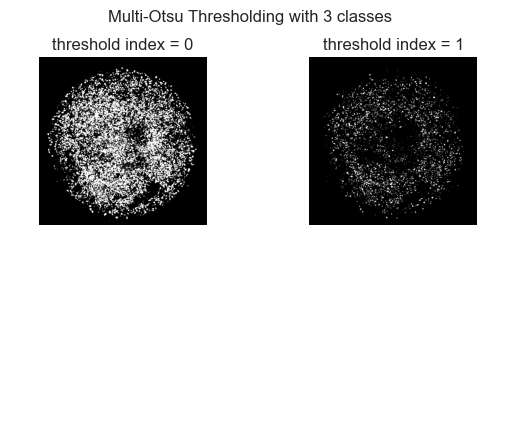

In [33]:
plot_multi_otsu_thresholds(cur_images[0], channel, 3)

In [34]:
index_to_exclude = [2, 3, 4]
cur_images = delete_from_list(cur_images, index_to_exclude)
cur_file_indexes = delete_from_list(cur_file_index, index_to_exclude)

dapi_num = 1

images_new.extend(list(map(
    lambda x:
    pipe(
        x,
        lambda f: apply_multiotsu_to_image(f, dapi_num, num_classes=3, threshold_index=0),
        lambda f: apply_multiotsu_to_channel(f, 0, num_classes=3, threshold_index=0)
    ),
    cur_images)
))

file_names_new.extend(get_items_from_index(file_names, cur_file_indexes))

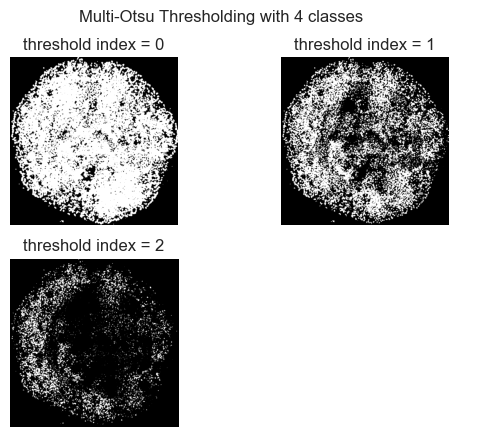

In [139]:
plot_multi_otsu_thresholds(v_new[0], 1, 4)

### Image Processing

In [35]:
def time_point(file):
    file_params = os.path.basename(file).split("_")
    return file_params[3]

In [36]:
df = []
channel_names = ["EdU", "DAPI"]

for file, img in zip(file_names_new, images_new):
    df_mini = generate_data_frame(
        expand_coordinate_matrix(img[dapi_num]),
        img,
        channel_names,
        Distances=get_distances(img[dapi_num])
    )
    df_mini = scale_distances(df_mini, file=file)
    df_mini = average_distances(df_mini, channel_names)
    df_mini = smooth_distances(df_mini, channel_names)
    df_mini["Time"] = np.repeat(time_point(file), df_mini.shape[0])
    df.append(df_mini)

df = pd.concat(df)

In [46]:
df.loc[
    (df["EdU"] > 0) &
    (df["Distances"] < 350) &
    (df["DAPI"] > 0)
    ].groupby("Time").count()["EdU"]

Time
18h    47570
24h    83524
28h    40773
Name: EdU, dtype: int64

In [47]:
df.loc[
    (df["EdU"] > 0) &
    (df["Distances"] < 350) &
    (df["DAPI"] > 0)
    ].groupby("Time").count()["DAPI"]

Time
18h    47570
24h    83524
28h    40773
Name: DAPI, dtype: int64

### Analysis

In [70]:
df_long = pd.melt(df, id_vars=["Time", "Distances"],
                  value_vars=["EdU", "DAPI"]).reset_index()
df_long = df_long.groupby(["Time", "Distances", "variable"]).mean()
df_long.reset_index(inplace=True)

In [65]:
col18 = df_long.loc[df_long["Time"] == "18h", "value"]
df_long.loc[df_long["Time"] == "18h", "value"] = (
        (col18 - col18.min()) / (col18.max() - col18.min())
)

col24 = df_long.loc[df_long["Time"] == "24h", "value"]
df_long.loc[df_long["Time"] == "24h", "value"] = (
        (col24 - col24.min()) / (col24.max() - col24.min())
)

col28 = df_long.loc[df_long["Time"] == "28h", "value"]
df_long.loc[df_long["Time"] == "28h", "value"] = (
        (col28 - col28.min()) / (col28.max() - col28.min())
)

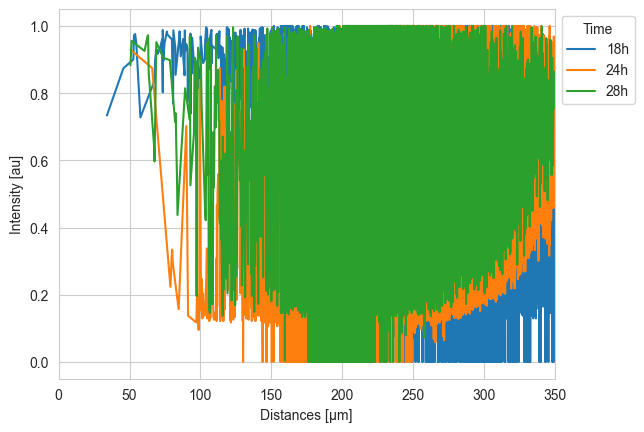

In [71]:
data = df_long.loc[
    (df_long["variable"] == "EdU")
]
g = sns.lineplot(data=data,
                 x="Distances",
                 y="value",
                 hue="Time")
g.set_xlabel("Distances [µm]")
g.set_ylabel("Intensity [au]")
g.set_xlim((0, 350))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [48]:
dict = {
    "Time": [f.split("\\")[0] for f in file_names_new],
    "Area Ratio":
        list(map(
            lambda x:
            regionprops((x[0] > 0).astype(int))[0].area /
            regionprops((x[1] > 0).astype(int))[0].area
            ,
            images_new
        )
        )
}

In [50]:
data = pd.DataFrame(dict)

In [54]:
data = data.groupby("Time").mean()
data.reset_index(inplace=True)

Text(1.8194444444444446, 0.5, 'EdU Area / DAPI Area [au]')

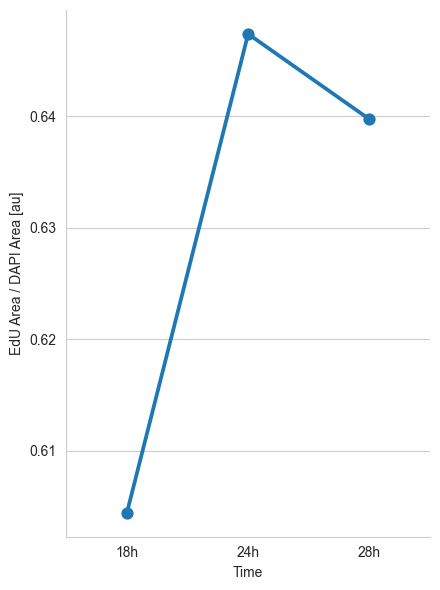

In [61]:
g = sns.catplot(data=data, x="Time", y="Area Ratio", errorbar="se",
                kind="point", height=6, aspect=.75)
g.ax.set_ylabel("EdU Area / DAPI Area [au]")